<a href="https://colab.research.google.com/github/mridul-eecs/self-driving-car/blob/master/self_driving_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/mridul-eecs/self-driving-car

Cloning into 'self-driving-car'...
remote: Enumerating objects: 19525, done.
remote: Total 19525 (delta 0), reused 0 (delta 0), pack-reused 19525
Receiving objects: 100% (19525/19525), 244.56 MiB | 14.44 MiB/s, done.
Checking out files: 100% (19526/19526), done.


In [2]:
 import numpy as np
 import matplotlib.pyplot as plt
 import matplotlib.image as mpimg
 import seaborn as sns
 import scipy.stats as stats
 from keras.models import Sequential
 from keras.optimizers import Adam
 from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
 import cv2
 from PIL import Image
 import random
 import pandas as pd
 import os
 from sklearn.utils import shuffle
 from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [3]:
datadir= 'self-driving-car/data'
columns= ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data= pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names= columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/home/mridul/Downloads/gephi-0.9.2/beta_simulator_linux/data/IMG/center_2020_01_26_14_02_15_460.jpg,/home/mridul/Downloads/gephi-0.9.2/beta_simulator_linux/data/IMG/left_2020_01_26_14_02_15_460.jpg,/home/mridul/Downloads/gephi-0.9.2/beta_simulator_linux/data/IMG/right_2020_01_26_14_02_15_460.jpg,0.000000,0.000000,0,9.468851
1,/home/mridul/Downloads/gephi-0.9.2/beta_simulator_linux/data/IMG/center_2020_01_26_14_02_15_566.jpg,/home/mridul/Downloads/gephi-0.9.2/beta_simulator_linux/data/IMG/left_2020_01_26_14_02_15_566.jpg,/home/mridul/Downloads/gephi-0.9.2/beta_simulator_linux/data/IMG/right_2020_01_26_14_02_15_566.jpg,0.000000,0.000000,0,9.373345
2,/home/mridul/Downloads/gephi-0.9.2/beta_simulator_linux/data/IMG/center_2020_01_26_14_02_15_672.jpg,/home/mridul/Downloads/gephi-0.9.2/beta_simulator_linux/data/IMG/left_2020_01_26_14_02_15_672.jpg,/home/mridul/Downloads/gephi-0.9.2/beta_simulator_linux/data/IMG/right_2020_01_26_14_02_15_672.jpg,0.122409,0.000000,0,9.276320
3,/home/mridul/Downloads/gephi-0.9.2/beta_simulator_linux/data/IMG/center_2020_01_26_14_02_15_772.jpg,/home/mridul/Downloads/gephi-0.9.2/beta_simulator_linux/data/IMG/left_2020_01_26_14_02_15_772.jpg,/home/mridul/Downloads/gephi-0.9.2/beta_simulator_linux/data/IMG/right_2020_01_26_14_02_15_772.jpg,0.407688,0.000000,0,9.140897
4,/home/mridul/Downloads/gephi-0.9.2/beta_simulator_linux/data/IMG/center_2020_01_26_14_02_15_876.jpg,/home/mridul/Downloads/gephi-0.9.2/beta_simulator_linux/data/IMG/left_2020_01_26_14_02_15_876.jpg,/home/mridul/Downloads/gephi-0.9.2/beta_simulator_linux/data/IMG/right_2020_01_26_14_02_15_876.jpg,0.043764,0.098427,0,9.057372


In [4]:
data['center'] = [i.split('/')[-1] for i in data['center']]
data['left'] = [i.split('/')[-1] for i in data['left']]
data['right'] = [i.split('/')[-1] for i in data['right']]
data.describe()

,steering,throttle,reverse,speed
count,6508.000000,6508.000000,6508.0,6508.000000
mean,-0.006103,0.988418,0.0,30.024432
std,0.126828,0.105440,0.0,1.545479
min,-0.923628,0.000000,0.0,4.987913
25%,0.000000,1.000000,0.0,30.189420
50%,0.000000,1.000000,0.0,30.190180
75%,0.000000,1.000000,0.0,30.190350
max,0.915177,1.000000,0.0,30.494350


In [5]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_01_26_14_02_15_460.jpg,left_2020_01_26_14_02_15_460.jpg,right_2020_01_26_14_02_15_460.jpg,0.000000,0.000000,0,9.468851
1,center_2020_01_26_14_02_15_566.jpg,left_2020_01_26_14_02_15_566.jpg,right_2020_01_26_14_02_15_566.jpg,0.000000,0.000000,0,9.373345
2,center_2020_01_26_14_02_15_672.jpg,left_2020_01_26_14_02_15_672.jpg,right_2020_01_26_14_02_15_672.jpg,0.122409,0.000000,0,9.276320
3,center_2020_01_26_14_02_15_772.jpg,left_2020_01_26_14_02_15_772.jpg,right_2020_01_26_14_02_15_772.jpg,0.407688,0.000000,0,9.140897
4,center_2020_01_26_14_02_15_876.jpg,left_2020_01_26_14_02_15_876.jpg,right_2020_01_26_14_02_15_876.jpg,0.043764,0.098427,0,9.057372


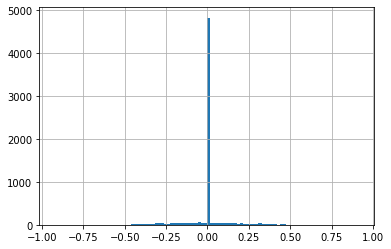

In [6]:
data.steering.hist(bins= 100)

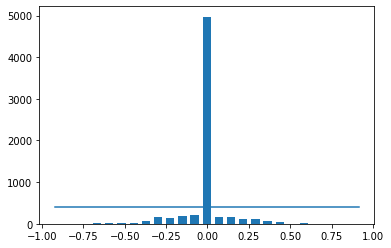

In [7]:
num_bins = 25
samples_per_bin = 400

hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 6508
removed: 4572
remaining: 1936


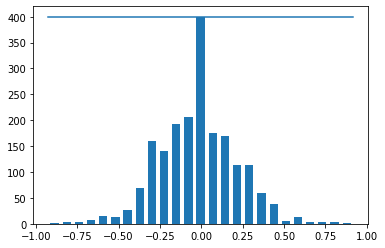

In [8]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [9]:
data.describe()

,steering,throttle,reverse,speed
count,1936.000000,1936.000000,1936.0,1936.000000
mean,-0.020014,0.990753,0.0,30.070460
std,0.231900,0.095499,0.0,1.272256
min,-0.923628,0.000000,0.0,5.046778
25%,-0.171199,1.000000,0.0,30.175918
50%,0.000000,1.000000,0.0,30.187515
75%,0.118418,1.000000,0.0,30.190210
max,0.915177,1.000000,0.0,30.249440


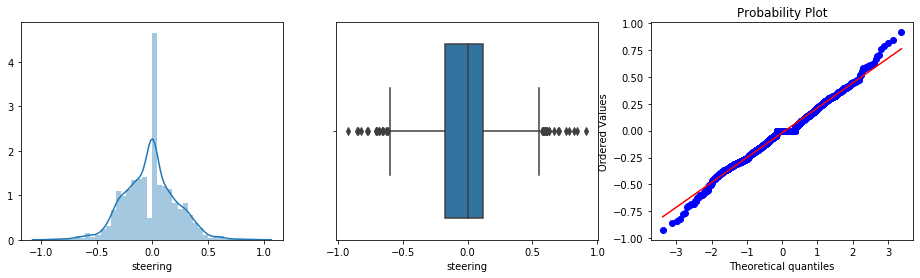

In [10]:
# removing outliers if there in the data 
def distribution(population):
  plt.figure(figsize= (16, 4))
  plt.subplot(1, 3, 1)
  sns.distplot(population)
  plt.subplot(1, 3, 2)
  sns.boxplot(population)
  plt.subplot(1, 3, 3)
  stats.probplot(population, dist= "norm", plot= plt)


distribution(data['steering'])

In [0]:
# We can see the distribution is nearby gaussian and seems normalized as well.
# We can clip outliers which are strong turning angles for smoother turning

In [12]:
# using 3 times IQR rule for this
Q75= data['steering'].quantile(0.75)
Q25= data['steering'].quantile(0.25)
IQR= abs(Q75-Q25)
lowerboundary= Q25 - (1.5*IQR)
higherboundary= Q75 + (1.5*IQR)
print(lowerboundary, higherboundary)

-0.6056251874999999 0.5528443125


In [13]:
data= data[data['steering'] > lowerboundary]
data= data[data['steering'] < higherboundary]
data.describe()

,steering,throttle,reverse,speed
count,1896.000000,1896.000000,1896.0,1896.000000
mean,-0.021266,0.990558,0.0,30.069213
std,0.211403,0.096492,0.0,1.285581
min,-0.600585,0.000000,0.0,5.046778
25%,-0.167971,1.000000,0.0,30.177080
50%,0.000000,1.000000,0.0,30.187865
75%,0.114711,1.000000,0.0,30.190223
max,0.551364,1.000000,0.0,30.249440


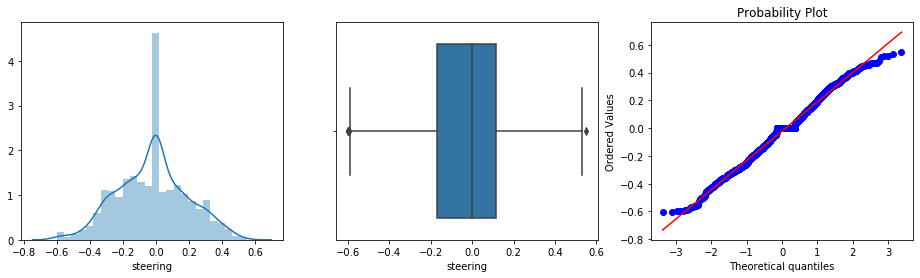

In [14]:
distribution(data['steering'])

In [0]:
# training and validation split
# in future we will try all 3 images and see the results
def load_image_steering(datadir, df):
  imagepath= []
  steering= []
  for i in range(len(data)):
    idx= data.iloc[i]
    center, left, right= idx[0], idx[1], idx[2]
    imagepath.append(os.path.join(datadir, center))
    steering.append(float(idx[3]))

  imagepath= np.asarray(imagepath)
  steering= np.asarray(steering)
  return imagepath, steering

imagedir= os.path.join(datadir, 'IMG')
features, labels= load_image_steering(imagedir, data)

In [16]:
xtrain, xtest, ytrain, ytest= train_test_split(features, labels, test_size= 0.2, random_state= 5)
print('trainining data', xtrain.shape, 'testing data', xtest.shape)

trainining data (1516,) testing data (380,)


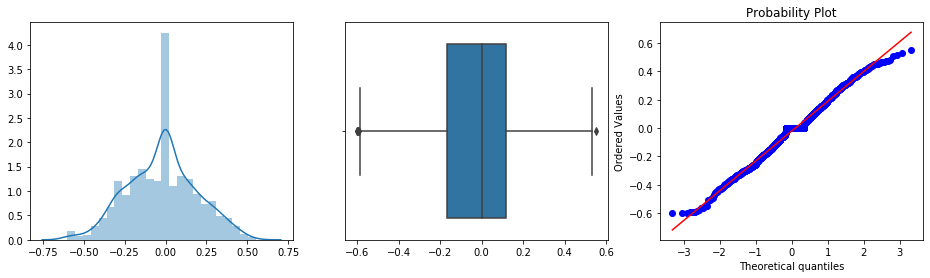

In [17]:
distribution(ytrain)

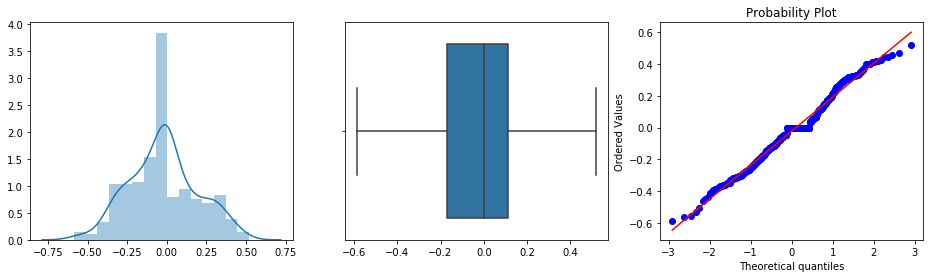

In [18]:
distribution(ytest)

In [0]:
# preprocessing images
def image_preprocess(image):
  img= mpimg.imread(image)
  img= img[60:140 ,: ,:] # Cropping horizon as its not necessary
  img= cv2.cvtColor(img, cv2.COLOR_RGB2YUV) # converting into YUV colorspace
  img= cv2.GaussianBlur(img, (3,3), 0) # Gaussian blurring to reduce noise
  img= cv2.resize(img, (200, 66)) # Prefered input size for the nvidia model
  img= img/255 # image normalization
  return img

self-driving-car/data/IMG/center_2020_01_26_14_06_19_591.jpg


Text(0.5, 1, 'Panned Image')

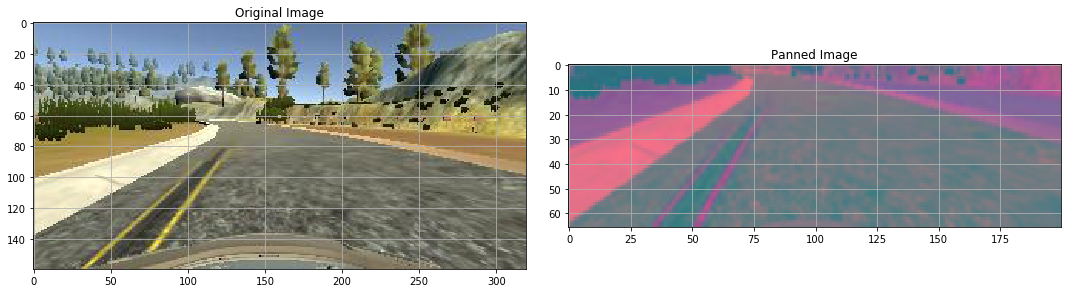

In [20]:
image = features[random.randint(0, 1000)]
print(image)
original_image = mpimg.imread(image)
panned_image = image_preprocess(image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].grid()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].grid()
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

(1516, 66, 200, 3)


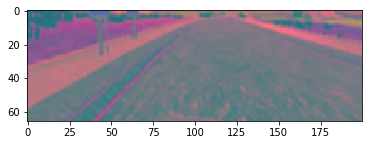

In [21]:
xtrain= np.array(list(map(image_preprocess, xtrain)))
xtest= np.array(list(map(image_preprocess, xtest)))
print(xtrain.shape)
plt.imshow(xtrain[random.randint(1, 100)])

In [27]:
def nvidia_model():
  model= Sequential()
  model.add(Conv2D(24, kernel_size= (5, 5), strides= (2, 2), input_shape= (66, 200, 3), activation= 'elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(36, kernel_size= (5, 5), strides= (2, 2), activation= 'elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(48, kernel_size= (5, 5), strides=(2, 2), activation= 'elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, kernel_size= (3, 3), activation= 'elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, kernel_size= (3, 3), activation= 'elu'))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(100, activation= 'elu'))
  model.add(BatchNormalization())
  model.add(Dense(50, activation= 'elu'))
  model.add(BatchNormalization())
  model.add(Dense(10, activation= 'elu'))
  model.add(BatchNormalization())
  model.add(Dense(1))
  optimizer= Adam(lr= 1e-3)
  model.compile(loss= 'mse', optimizer= optimizer)
  return model

net= nvidia_model()
net.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
batch_normalization_9 (Batch (None, 31, 98, 24)        96        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
batch_normalization_10 (Batc (None, 14, 47, 36)        144       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
batch_normalization_11 (Batc (None, 5, 22, 48)         192       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 20, 64)        

In [28]:
history= net.fit(xtrain, ytrain, epochs= 30, validation_data= (xtest, ytest), batch_size= 100, verbose= 1, shuffle= 1)

Train on 1516 samples, validate on 380 samples
Epoch 1/30
1516/1516 [==============================] - 2s 2ms/step - loss: 0.3201 - val_loss: 0.1817
Epoch 2/30
1516/1516 [==============================] - 1s 422us/step - loss: 0.0276 - val_loss: 0.0675
Epoch 3/30
1516/1516 [==============================] - 1s 409us/step - loss: 0.0213 - val_loss: 0.0414
Epoch 4/30
1516/1516 [==============================] - 1s 412us/step - loss: 0.0179 - val_loss: 0.0280
Epoch 5/30
1516/1516 [==============================] - 1s 421us/step - loss: 0.0183 - val_loss: 0.0216
Epoch 6/30
1516/1516 [==============================] - 1s 401us/step - loss: 0.0169 - val_loss: 0.0204
Epoch 7/30
1516/1516 [==============================] - 1s 419us/step - loss: 0.0147 - val_loss: 0.0193
Epoch 8/30
1516/1516 [==============================] - 1s 418us/step - loss: 0.0156 - val_loss: 0.0215
Epoch 9/30
1516/1516 [==============================] - 1s 406us/step - loss: 0.0144 - val_loss: 0.0184
Epoch 10/30
1516/15

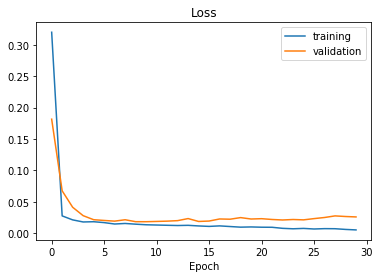

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
net.save('model.h5')
from google.colab import files
files.download('model.h5')